# BikewaySim Routing

In [32]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

import impedance_calibration.stochastic_optimization as stochastic_optimization
from network.src import modeling_turns


# Import ODs

In [33]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))


# Import Network

In [34]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)

## Process the improvements

In [35]:
#remove improvements that aren't improvements
links.loc[links['facility_fwd']==links['improvement'],'improvement'] = None
# links.loc[links['improvement'].notna(),['facility_fwd','improvement']]

#change cycletracks to multi use paths for now
change_infra = {
    'buffered bike lane': 'bike lane',
    'cycletrack': 'multi use path'
}
links['improvement'] = links['improvement'].apply(lambda x: change_infra.get(x,x))
links['facility_fwd'] = links['facility_fwd'].apply(lambda x: change_infra.get(x,x))

#combine facilities into one
import numpy as np
links['facility_fwd_new'] = np.where(links['improvement'].notna(),links['improvement'],links['facility_fwd'])

<AxesSubplot: >

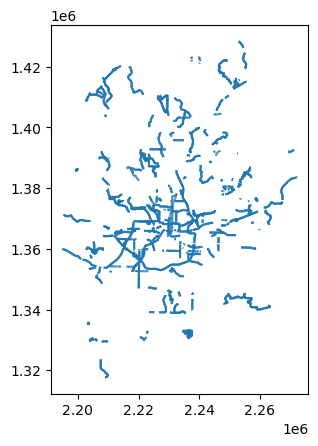

In [36]:
links[links['facility_fwd_new'].notna()].plot()

In [37]:
#import the coa id back in so that we can aggregate by the faciility
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')[['coa_id','linkid']]
improvements = links.loc[links['improvement'].notna()].copy()
improvements = pd.merge(improvements[['linkid','facility_fwd_new','geometry']],facility_ids,on='linkid')
improvements.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements')

improvements_buffer = improvements.copy()
improvements_buffer.geometry = improvements_buffer.buffer(200)
improvements_buffer = improvements_buffer.dissolve('coa_id').reset_index()
improvements_buffer.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements_buffer')

# Select Calibration Results to Get Coefficients

In [38]:
#BUG saved calibration coefficients are wrong
calibration_results[-1]

{'multi use path': -0.14827102335300216,
 'bike lane': -0.44874582723328715,
 'lanes': 0.9773461720577385,
 'above_4': 2.683598621716529,
 'unsig_major_road_crossing': 7.6504858673043,
 'loss': -0.3081016034970768,
 'beta_links': {0: 'multi use path', 1: 'bike lane', 2: 'lanes', 3: 'above_4'},
 'beta_turns': {4: 'unsig_major_road_crossing'}}

In [39]:
#selects the last one used
#bug, 
calibration_result = calibration_results[-1]
betas = [-0.184, -0.398, 0.126, 0.325, 0.324]#list(calibration_result.values())[0:-3]
betas_links = calibration_result['beta_links']
betas_turns = calibration_result['beta_turns']

# Travel Time Routing

In [40]:
from importlib import reload
reload(stochastic_optimization)

# run impedance routing on all the provided ODs 170 mins
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)


In [41]:
#results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}
# with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('wb') as fh:
#     pickle.dump(results_dict,fh)

# Shortest Path Routing


In [42]:
# create the neccessary attributes for impednaces
links['bike lane'] = (links['facility_fwd'] == 'bike lane').astype(int)
links['multi use path'] = (links['facility_fwd'] == 'multi use path').astype(int)
links.loc[links['multi use path']==1,'lanes'] = 0

In [43]:
from importlib import reload
reload(stochastic_optimization)

# run impedance routing on all the provided ODs
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          stochastic_optimization.link_impedance_function,
                          base_impedance_col,
                          stochastic_optimization.turn_impedance_function,
                          links,turns,turn_G)
current_links = links.copy()

[-0.184, -0.398, 0.126, 0.325, 0.324]


In [44]:
#export the current network
current_links[['linkid','reverse_link','travel_time_min','multiplier','link_cost','geometry']].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network')

In [45]:
# #170 minutes
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}

# with (config['bikewaysim_fp']/"current_results.pkl").open('wb') as fh:
#     pickle.dump(results_dict,fh)


# Repeat with Network Improvements


In [46]:
#update the bike lane, multi use path, and lanes attributes
links['bike lane'] = (links['facility_fwd_new']=='bike lane').astype(int)
links['multi use path'] = (links['facility_fwd_new']=='multi use path').astype(int)

#for multiuse paths, make sure to set the lanes attribute to zero
links.loc[links['multi use path']==1,'lanes'] = 0

In [47]:
from importlib import reload
reload(stochastic_optimization)

# run impedance routing on all the provided ODs
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          stochastic_optimization.link_impedance_function,
                          base_impedance_col,
                          stochastic_optimization.turn_impedance_function,
                          links,turns,turn_G)
future_links = links.copy()


[-0.184, -0.398, 0.126, 0.325, 0.324]


In [48]:
#export the current network
future_links[['linkid','reverse_link','travel_time_min','multiplier','link_cost','geometry']].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network')

In [49]:
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}
# with (config['bikewaysim_fp']/"future_results.pkl").open('wb') as fh:
#     pickle.dump(results_dict,fh)